In [1]:
%matplotlib inline

import os
import sys
import cv2
import torch
import torchvision
from torchvision.ops.boxes import masks_to_boxes

import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

    
from video_processing.yolov7.dataset.utils import read_image, inverse_image_n_boxes_to_target_size, image_n_boxes_to_target_size
from video_processing.misc import alpha_bending
from video_processing.yolov7.dataset.coords import xyxy2xywh, xywh2xyxy, normalized_xywh2xyxy


In [3]:
class PennFudanDataset(torch.utils.data.Dataset):

    def __init__(self, root, image_dirname, mask_dirname, indices=None, img_size=1280, augment=False, correct_exif=True,
                 padding_value=(114,114,114)):
        '''
        Input:
            root (str): path to data folder
            image_dirname (str): name of subfolder containing images
            mask_dirname (str): name of subfolder containing masks
            indices (sequence): indices to data used
        '''
        self.augment=augment
        self.img_size=img_size
        self.correct_exif=correct_exif
        self.padding_value=padding_value
        self.image_dirpath=os.path.join(root, image_dirname).encode('utf-8')
        self.mask_dirpath=os.path.join(root, mask_dirname).encode('utf-8')

        self.image_fnames=np.asarray(sorted(s.encode('utf-8') for s in os.listdir(self.image_dirpath.decode('utf-8')))) # decode s.decode('utf-8')
        self.mask_fnames=np.asarray(sorted(s.encode('utf-8') for s in os.listdir(self.mask_dirpath.decode('utf-8')))) # decode s.decode('utf-8')
        if indices is None: indices=np.arange(len(self.image_fnames))
        if max(indices)<len(self.image_fnames):
            self.image_fnames=[self.image_fnames[idx] for idx in indices]
            self.mask_fnames=[self.mask_fnames[idx] for idx in indices]

        # make sure that files are ordered consistently
        for im, msk in zip(self.image_fnames, self.mask_fnames):
            im=im.decode('utf-8')
            msk=msk.decode('utf-8')
            assert all(os.path.splitext(im)[0]==os.path.splitext(x)[0].replace('_mask', '') for x in [msk])

    def __len__(self):
        return len(self.image_fnames)

    def __getitem__(self, idx):

        idx=idx%len(self.image_fnames)

In [4]:
root='D:/data/PennFudanPed'
dataset=PennFudanDataset(root=root, image_dirname='PNGImages', mask_dirname='PedMasks', indices=None, 
                        img_size=1280, augment=True, correct_exif=True,padding_value=(114,114,114))

In [5]:
idx=0

image_fpath=os.path.join(dataset.image_dirpath.decode('utf-8'), dataset.image_fnames[idx].decode('utf-8'))
mask_fpath=os.path.join(dataset.mask_dirpath.decode('utf-8'), dataset.mask_fnames[idx].decode('utf-8'))


image,(H0,W0)=read_image(image_fpath, target_size=dataset.img_size, correct_exif=dataset.correct_exif)
mask,_=read_image(mask_fpath, target_size=dataset.img_size, correct_exif=dataset.correct_exif, mode='nearest')
#image=torch.from_numpy(image).permute(2,0,1) #CxHxW  -> CxYxX
mask=torch.from_numpy(mask)[None] # CxHxW -> CxYxX

In [6]:
# instances are encoded with different colors
obj_ids=torch.unique(mask)
print('obj_ids ', obj_ids)
# first id is the background, so remove it
obj_ids=obj_ids[1:]
print('obj_ids ', obj_ids)
n_objs=len(obj_ids)
# first we split the color-encoded mask into a set of binary masks
masks=(mask==obj_ids[:,None,None]).to(dtype=torch.uint8) # LxHxW or LxYxX where L is the number of objects
print('masks ', masks.shape)
class_idx=torch.ones(n_objs,dtype=torch.long)[:,None] # Nx1 where N is the number of boxes. Note there is only 1 class
image_id=torch.tensor([idx]).repeat(n_objs)[:,None] # Nx1

boxes=masks_to_boxes(masks) # Nx4 where N is the number of objects and 4 for x-min,y-min,x-max,y-max
# boxes=xyxy2xywh(boxes) # Nx4 where N is the number of objects and 4 for x-center, y-center, width, height
# # normalized boxes by image width and height so every term is the range 0-1
# boxes[:,[0,2]]/=mask.shape[-1]
# boxes[:,[1,3]]/=mask.shape[-2]

# labels=torch.cat((image_id, class_idx, boxes), dim=-1)
# labels.shape, labels

obj_ids  tensor([0, 1, 2], dtype=torch.uint8)
obj_ids  tensor([1, 2], dtype=torch.uint8)
masks  torch.Size([2, 1227, 1280])


img  torch.Size([1, 3, 1227, 1280]) torch.uint8


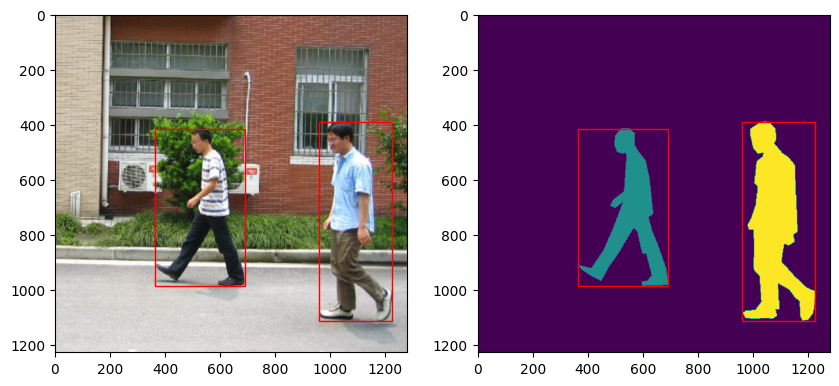

In [7]:
import matplotlib.patches as patches


img=torch.from_numpy(image).permute(2,0,1).contiguous()[None] if not isinstance(image, torch.Tensor) else image[None]
msk=None #mask[None] 
print('img ', img.shape, img.dtype)
blended_img=alpha_bending(foreground=msk, background=img, alpha=0.5) if msk is not None else img

_, ax=plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(blended_img.to(torch.uint8).squeeze(dim=0).permute(1,2,0))
ax[1].imshow(mask.squeeze())
boxes_=boxes #normalized_xywh2xyxy(boxes, w=mask.shape[-1], h=mask.shape[-2])
for box in boxes_:
    rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

boxes  torch.Size([2, 4]) tensor([365., 390., 691., 986.]) tensor([ 960.,  415., 1225., 1112.])
boxes  torch.Size([2, 4]) tensor([ 365.0000,  416.5000,  691.0000, 1012.5000]) tensor([ 960.0000,  441.5000, 1225.0000, 1138.5000])
image  (1227, 1280, 3)  adjusted_image  (1280, 1280, 3)
img  torch.Size([1, 3, 1280, 1280]) torch.uint8


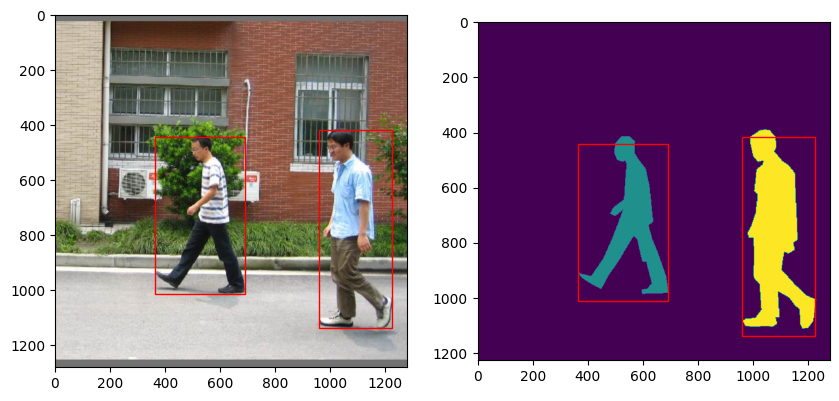

In [9]:
image_size=image.shape
print('boxes ', boxes.shape, boxes.min(0).values, boxes.max(0).values)
adjusted_image, ratio, (shift_x, shift_y)=image_n_boxes_to_target_size(image, boxes, target_size=dataset.img_size, scale_up=True, color=(114,114,114), eps=1.e-4)
print('boxes ', boxes.shape, boxes.min(0).values, boxes.max(0).values)
print('image ', image.shape, ' adjusted_image ', adjusted_image.shape)

img=torch.from_numpy(adjusted_image  ).permute(2,0,1).contiguous()[None] if not isinstance(adjusted_image  , torch.Tensor) else adjusted_image[None]
msk=None #mask[None] 
print('img ', img.shape, img.dtype)
blended_img=alpha_bending(foreground=msk, background=img, alpha=0.5) if msk is not None else img

_, ax=plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(blended_img.to(torch.uint8).squeeze(dim=0).permute(1,2,0))
ax[1].imshow(mask.squeeze())
boxes_=boxes #normalized_xywh2xyxy(boxes, w=mask.shape[-1], h=mask.shape[-2])
for box in boxes_:
    rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

In [10]:
print(image_size, image.shape)
print('ratio ', ratio, ' shift ', (shift_x, shift_y))
print(type(boxes), boxes)

(1227, 1280, 3) (1227, 1280, 3)
ratio  1.0  shift  (0.0, 26.5)
<class 'torch.Tensor'> tensor([[ 365.0000,  441.5000,  691.0000, 1012.5000],
        [ 960.0000,  416.5000, 1225.0000, 1138.5000]])


img  torch.Size([1, 3, 1227, 1280]) torch.uint8


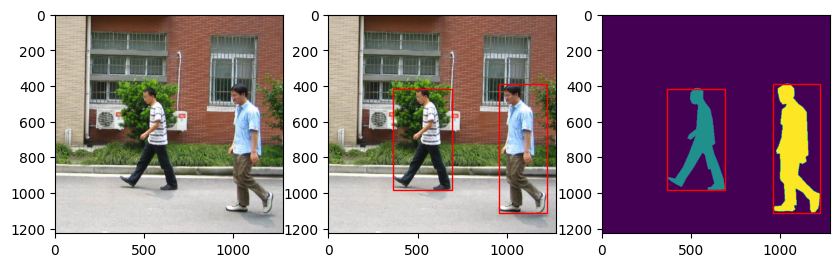

In [11]:
original_boxes=inverse_image_n_boxes_to_target_size(boxes, ratio, shift_x, shift_y)

img=torch.from_numpy(image).permute(2,0,1).contiguous()[None] if not isinstance(image  , torch.Tensor) else image[None]
msk=None #mask[None] 
print('img ', img.shape, img.dtype)
blended_img=alpha_bending(foreground=msk, background=img, alpha=0.5) if msk is not None else img

_, ax=plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(image)
ax[1].imshow(blended_img.to(torch.uint8).squeeze(dim=0).permute(1,2,0))
ax[2].imshow(mask.squeeze())
boxes_=original_boxes #normalized_xywh2xyxy(boxes, w=mask.shape[-1], h=mask.shape[-2])
for box in boxes_:
    rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)